# Sistema de inventario

Este código hace una simulación de inventario utilizando la biblioteca simpy.

In [ ]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importamos simpy & numpy
import simpy
import numpy as np

In [ ]:
#La función toma 3 argumentos
#order_cutoff es el nivel de inventario mínimo en el cual se debe realizar un nuevo pedido
#order_target es el tamaño del pedido a realizar cuando se alcanza el punto de reorden.
def warehouse_run(env, order_cutoff, order_target): #La función toma 3 argumentos
  global inventory, balance, num_ordered
#Las variables inventory, balance y num_ordered se inicializan.
#Estas variables se utilizan para llevar un seguimiento del inventario actual, el saldo financiero y el número de pedidos en curso.
  inventory= order_target
  balance= 0.0
  num_ordered=0

  while True:
    interarrival = generate_interarrival() #Se genera un tiempo de llegada entre eventos utilizando la función generate_interarrival().
    #Este tiempo representa el intervalo de tiempo entre eventos de llegada
    yield env.timeout(interarrival) #Se utiliza yield env.timeout(interarrival) para pausar la ejecución de la función durante el tiempo de llegada generado.
    balance -= inventory*2*interarrival #Se actualiza el saldo (balance) restando el costo de mantener el inventario durante el intervalo  de tiempo transcurrido
    demand= generate_demand() #Esta función representa la cantidad de productos que se demandan en un determinado intervalo de tiempo.

#Se evalúa si la demanda es menor que el inventario actual. Si es así, se procesa la venta.
#Se actualiza el saldo sumando el ingreso generado por la venta (100 veces la demanda) y se reduce el inventario en la cantidad vendida.
#Luego, se imprime un mensaje indicando el tiempo actual y la cantidad vendida.

#Si la demanda es igual o mayor que el inventario, se procesa la venta de todo el inventario disponible.
#El saldo se actualiza de la misma manera que en el punto anterior, pero el inventario se establece en cero.
#Se imprime un mensaje indicando el tiempo actual y que el inventario se agotó.
    if demand < inventory:
      balance= 100*demand
      inventory -= demand
      print ('{:.2f} sold {}'.format(env.now, inventory))
    else:
      balance+= 100*inventory
      inventory = 0
      print ('{:.2f} sold {} (out of stock)'.format(env.now, inventory))
#Se verifica si el inventario está por debajo del punto de reorden y si no hay pedidos en curso
# Si ambas condiciones se cumplen, se inicia el proceso de manejo del pedido utilizando env.process(handle_order(env))
#La función handle_order se encargará de realizar el pedido al proveedor y actualizar las variables correspondientes.

    if inventory < order_cutoff and num_ordered == 0:
       env.process(handle_order(env,order_target))

In [ ]:
#La función handle_order,  se encarga de procesar un pedido de inventario al proveedor en la simulación del almacén.
def handle_order(env, order_target):
  global inventory, balance, num_ordered

#num_ordered se calcula como la diferencia entre el objetivo de pedido (order_target) y el inventario actual.
#Esto representa la cantidad de productos que se deben pedir para alcanzar el nivel objetivo de inventario.
  num_ordered=order_target-inventory
#Se imprime un mensaje indicando el tiempo actual (env.now) y la cantidad de productos que se han pedido (num_ordered)
  print ('{:.2f} placed order for{}'.format(env.now,num_ordered))
#El saldo (balance) se actualiza restando el costo de realizar el pedido.
#En este caso, se asume un costo fijo de 50 unidades por cada producto pedido.
  balance -=50*num_ordered
#Se utiliza yield env.timeout(2.0) para simular el tiempo que lleva recibir el pedido del proveedor.
#El tiempo de espera de 2.0 unidades representa el tiempo de entrega estimado.
  yield env.timeout(2.0)
#Una vez que ha pasado el tiempo de espera, se actualiza el inventario agregando la cantidad de productos pedidos (num_ordered).
  inventory += num_ordered
#La variable num_ordered se restablece a cero, ya que se ha completado el pedido.
  num_ordered = 0
#Se imprime un mensaje indicando el tiempo actual y la cantidad de productos en el inventario después de recibir el pedido
  print ('{:.2f} received order, {} in inventory'.format(env.now, inventory))



In [ ]:
#La función generate_interarrival utiliza la función np.random.exponential de la biblioteca numpy.
#Esta función genera números aleatorios a partir de una distribución exponencial.
def generate_interarrival():
  return np.random.exponential(1./5) #Se desea generar números aleatorios siguiendo una distribución exponencial con un parámetro de tasa 0.2.
#La función np.random.exponential devuelve un número aleatorio que representa el tiempo entre eventos en la simulación.

In [ ]:
def generate_demand(): #generate_demand, genera una demanda de productos en la simulación del almacén.
  return np.random.randint(1,5) #La función np.random.randint devuelve un número entero aleatorio que representa la demanda de productos en la simulación.
  #El número generado estará en el rango especificado.

In [ ]:
obs_time=[] #se utiliza para almacenar los tiempos de observación en la simulación del almacén. Esta lista
#se puede utilizar para registrar los momentos en los que se desea observar y registrar el estado del inventario u otros parámetros del sistema.
inventory_level=[] #se utiliza para almacenar los niveles de inventario en la simulación del almacén en los momentos de observación.
#Cada vez que se realiza una observación del inventario, se puede agregar el nivel actual del inventario a esta lista.

In [ ]:
def observe (env):
  global inventory #cualquier modificación que se haga a inventory dentro de la función afectará a la variable global.
  while True:
    obs_time.append(env.now) #agrega el tiempo actual a la lista
    inventory_level.append(inventory)
    yield env.timeout(0.1) #hace que la función se pause durante 0.1 unidades de tiempo. Después de ese tiempo,
    #la ejecución de la función se reanudar

In [ ]:
np.random.seed(0) #Se establece la semilla del generador de numeros

In [ ]:
env=simpy.Environment()
env.process(warehouse_run(env, 10, 30)) # inicia la simulación del almacén con un punto de reorden de 10 y un objetivo de pedido de 30.
#El proceso se agrega al entorno de simulación para su ejecución.
env.process(observe(env)) #Este proceso se encargará de realizar observaciones periódicas del inventario en la simulación.


<Process(observe) object at 0x7fa24330ec80>

In [ ]:
env.run(until=5.0) #Ejecuta la simulación del entorno env hasta que el tiempo alcanza 5.0 unidades

0.16 sold 28
0.53 sold 24
0.69 sold 22
0.88 sold 19
1.00 sold 16
1.01 sold 15
1.11 sold 12
1.44 sold 9
1.44 placed order for21
1.61 sold 7
1.97 sold 6
1.99 sold 2
2.08 sold 0 (out of stock)
2.38 sold 0 (out of stock)
2.79 sold 0 (out of stock)
3.11 sold 0 (out of stock)
3.26 sold 0 (out of stock)
3.28 sold 0 (out of stock)
3.44 received order, 21 in inventory
3.46 sold 19
4.04 sold 15
4.06 sold 11
4.12 sold 7
4.12 placed order for23
4.39 sold 6
4.56 sold 5
4.63 sold 3
4.82 sold 2
4.92 sold 1


Text(0, 0.5, 'Inventory label')

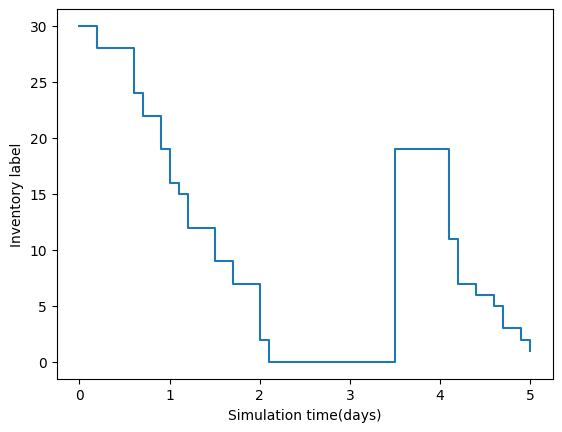

In [ ]:
#Generamos la gráfica
import matplotlib.pyplot as plt
plt.figure()
plt.step(obs_time, inventory_level, where='post')
plt.xlabel('Simulation time(days)')
plt.ylabel('Inventory label')